In [1]:
import numpy as np
import pyvinecopulib as pv

from gcimpute.gaussian_copula import GaussianCopula
from gcimpute.helper_evaluation import get_smae
from vcimpute.helper_datagen import mask_MCAR

In [2]:
def make_copula(d):
    structure = pv.DVineStructure.simulate(d)

    pair_copulas = []
    for j in range(d - 1):
        tmp = []
        pair_copulas.append(tmp)
        for _ in range(d - j - 1):
            rho = np.minimum(np.maximum(np.random.beta(1, 0.75), 0.01), 0.99)
            tmp.append(pv.Bicop(family=pv.BicopFamily.gaussian, parameters=[[rho]]))

    cop = pv.Vinecop(structure, pair_copulas)

    return cop

In [44]:
cop = make_copula(d)
X = cop.simulate(n=1000)
m = cop.order[0]-1
X_mask = None
k=0
while (X_mask is None) or (not np.any(np.isnan(X_mask[:,m]))):
    k+=1
    X_mask = mask_MCAR(X, 'univariate', mask_fraction, k)

### timing

In [ ]:
%timeit GaussianCopula().fit_transform(X_mask)

In [52]:
miss_vars = [m+1]
obs_vars = list(set(1 + np.arange(d)).difference(miss_vars))
structure = pv.DVineStructure(order=miss_vars + obs_vars)

cop2 = pv.Vinecop(structure)
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.gaussian])
cop2.select(X_mask, controls=controls)

def proc2():

    rb = cop2.rosenblatt(X_mask)
    nan_rows = np.isnan(rb[:,m])
    rb[nan_rows, m] = np.random.uniform(size=np.count_nonzero(nan_rows))
    irb = cop2.inverse_rosenblatt(rb[nan_rows,:])
    Ximp2 = np.copy(X_mask)
    Ximp2[nan_rows, m] = irb[:, m]

In [53]:
%timeit proc2()

5.27 s ± 50.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit proc2()

29.4 s ± 75.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### accuracy

In [14]:
l=0
out = []
for d in np.arange(5,100,step=5):
    for mask_fraction in [0.01,0.025,0.05,0.1,0.15,0.175,0.2]:
        cop = make_copula(d)
        X = cop.simulate(n=1000)
        m = cop.order[0]-1
        X_mask = None
        k=0
        while (X_mask is None) or (not np.any(np.isnan(X_mask[:,m]))):
            k+=1
            X_mask = mask_MCAR(X, 'univariate', mask_fraction, k)

        X_imp = GaussianCopula().fit_transform(X_mask)
        

        miss_vars = [m+1]
        obs_vars = list(set(1 + np.arange(d)).difference(miss_vars))
        structure = pv.DVineStructure(order=miss_vars + obs_vars)

        cop2 = pv.Vinecop(structure)
        controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.gaussian])
        cop2.select(X_mask, controls=controls)

        rb = cop2.rosenblatt(X_mask)
        nan_rows = np.isnan(rb[:,m])
        rb[nan_rows, m] = np.random.uniform(size=np.count_nonzero(nan_rows))
        irb = cop2.inverse_rosenblatt(rb[nan_rows,:])
        Ximp2 = np.copy(X_mask)
        Ximp2[nan_rows, m] = irb[:, m]
        
        out.append((
            d,
            mask_fraction,
            get_smae(X_imp, X, X_mask)[m],
            get_smae(Ximp2, X, X_mask)[m]
        ))
        print(l)
        l+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

### Check result

In [15]:
from matplotlib import pyplot as plt

In [18]:
import pandas as pd

In [19]:
df = pd.DataFrame(out, columns=[['d', 'mask_frac', 'smae_gc', 'smae_vc']])

In [20]:
df.to_pickle('univ_irb.pkl')

(array([17.,  4.,  1.,  5.,  0.,  0.,  1.,  0.,  1.,  1.]),
 array([0.02737724, 0.09851347, 0.16964971, 0.24078595, 0.31192218,
        0.38305842, 0.45419465, 0.52533089, 0.59646713, 0.66760336,
        0.7387396 ]),
 <BarContainer object of 10 artists>)

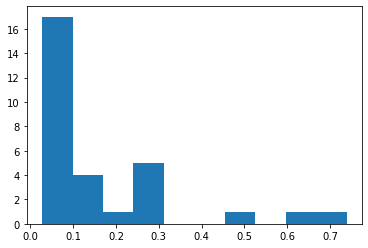

In [32]:
plt.hist(df['smae_gc'])

In [42]:
df['smae_vc'].mean()

smae_vc    0.162952
dtype: float64

In [43]:
df['smae_vc'].std()

smae_vc    0.231166
dtype: float64

(-0.0365239485345842, 0.8322537527125379)

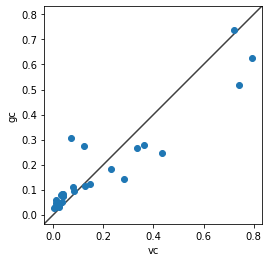

In [37]:
plt.scatter(df['smae_vc'], df['smae_gc'])
plt.xlabel('vc')
plt.ylabel('gc')
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)


(array([18.,  4.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,  3.]),
 array([0.00296595, 0.08194574, 0.16092553, 0.23990532, 0.31888511,
        0.3978649 , 0.47684469, 0.55582448, 0.63480428, 0.71378407,
        0.79276386]),
 <BarContainer object of 10 artists>)

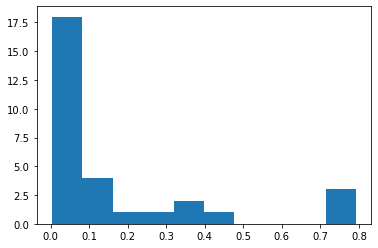

In [33]:
plt.hist(df['smae_vc'])

In [24]:
df.groupby('mask_frac')

ValueError: Grouper for 'mask_frac' not 1-dimensional